In [253]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from scipy.ndimage.interpolation import shift
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib
import matplotlib.pyplot as plt

In [254]:
temperatureData = pd.read_csv("Data/daily-minimum-temperatures-in-me.csv", dtype={'Temperature': float})
temperatureData.head()

,Date,Temperature
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


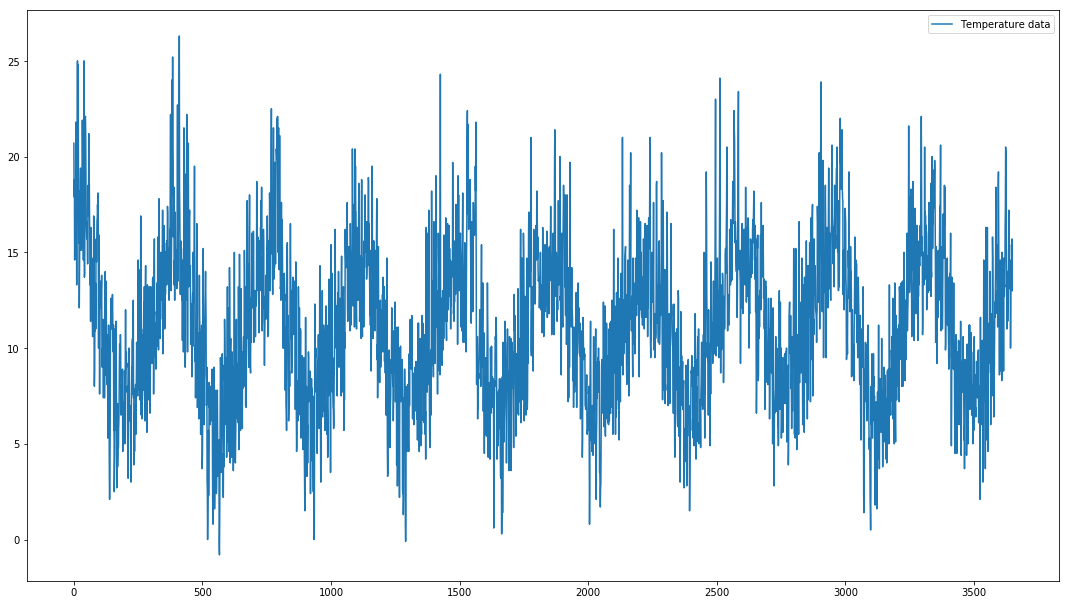

In [255]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(temperatureData['Temperature'].values, label = "Temperature data")
plt.legend()
plt.savefig("TemperatureData.png")

In [256]:
passengersData = pd.read_csv("Data/AirPassengers.csv")
passengersData.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


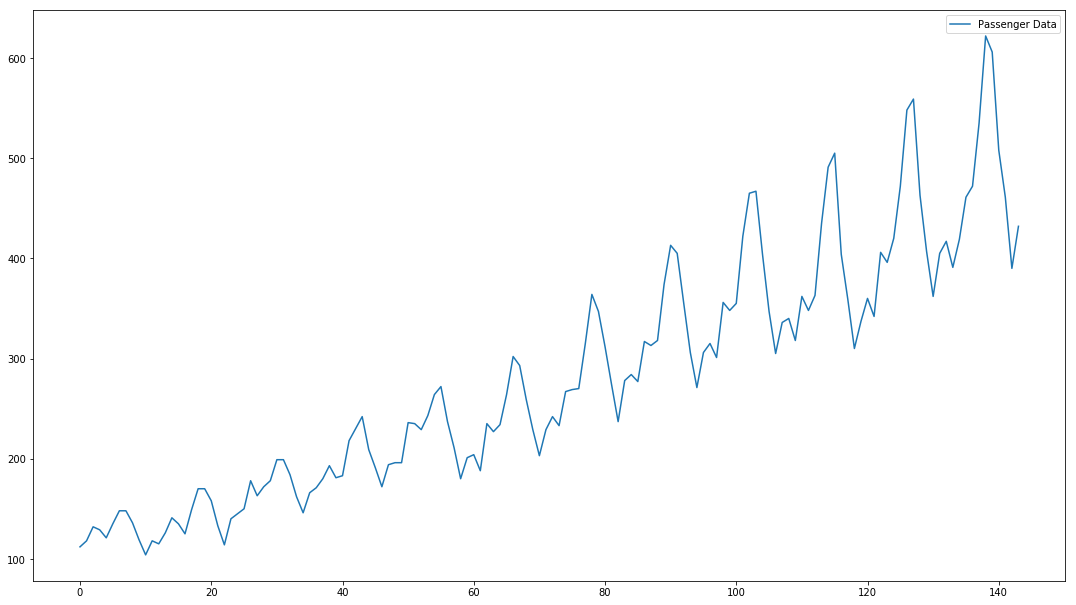

In [257]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(passengersData['#Passengers'].values, label = "Passenger Data")
plt.legend()
plt.savefig("PassengerData.png")

### Test stationarity

In [258]:
def isSeriesStationary(series):
    pValue = adfuller(series)[1]
    if pValue > 0.05:
        return False
    else:
        return True

In [259]:
def isSeriesStationaryAvg(series, delta = 2):
    split = int(len(series)/2)
    split1, split2 = series[:split], series[split:]
    avg1, avg2 = split1.mean(), split2.mean()
    var1, var2 = split1.var(), split2.var()
    if abs(avg1 - avg2) > delta or abs(var1 - var2) > delta**2:
        return False
    else:
        return True

## Make time series starionary

In [260]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)

def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

def describeSeries(data, label):
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.plot(data, label = "Series")
    plt.plot(pd.rolling_mean(data, window = 2), '--', label = "Rolling mean")
    plt.plot(pd.rolling_std(data, 2), ":", label = "Rolling Std")
    plt.legend()
    plt.savefig(label)
    plt.clf()

In [261]:
describeSeries(passengersData['#Passengers'], "DescribePassengers.png")
describeSeries(temperatureData['Temperature'].values, "DescribeTemperature.png")

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:15: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=2).mean()
  from ipykernel import kernelapp as app
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:16: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=2).std()
  app.launch_new_instance()
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:15: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  from ipykernel import kernelapp as app
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:16: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  app.launch_new_instance()


<Figure size 1332x756 with 0 Axes>

In [262]:
def splitTrainTest(series, testSplit):
    totalData = len(series)
    trainSplit = int(totalData * (1 - testSplit))
    trainSet = series[:trainSplit]
    testSet = series[trainSplit:]
    return trainSet, testSet

### For temperature data

In [263]:
isSeriesStationaryAvg(temperatureData["Temperature"].values)

True

In [264]:
isSeriesStationary(temperatureData["Temperature"].values)

True

In [265]:
trainSet, testSet = splitTrainTest(temperatureData["Temperature"].values, 0.1)

In [266]:
differencedTrainSet = difference(trainSet, 365)
model = ARIMA(differencedTrainSet, order=(7,0,1))
"""Fit model with non constant trend and no displacement"""
model_fit = model.fit(disp = 0)
forecast = model_fit.predict(len(differencedTrainSet), len(differencedTrainSet) + len(testSet))

/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


In [267]:
yPrediction = []
history = list(trainSet)
for f in forecast:
    yPredict = inverse_difference(history, f, 365)
    yPrediction.append(yPredict)
    history.append(yPredict)

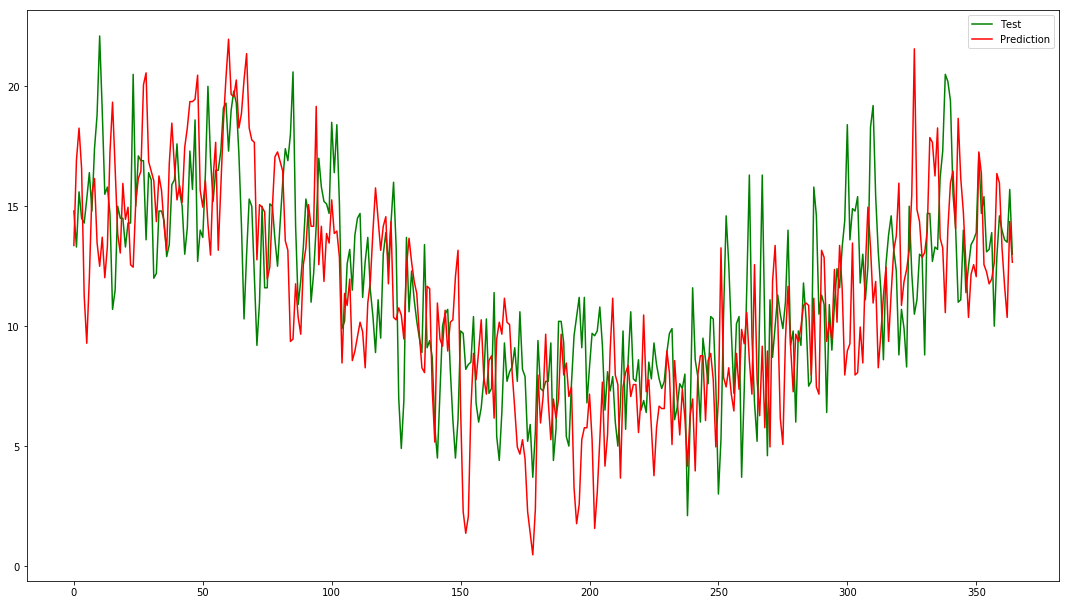

In [268]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(testSet, color='green', label = "Test")
plt.plot(yPrediction[:-1], color='red', label = "Prediction")
plt.legend()
plt.savefig("TemperaturePrediction.png")

In [269]:
print(sqrt(mean_squared_error(testSet, yPrediction[:-1])))

3.656227448017754


### For passenger data set

In [270]:
isSeriesStationaryAvg(passengersData["#Passengers"].values)

False

In [271]:
isSeriesStationary(passengersData["#Passengers"].values)

False

In [272]:
series = passengersData["#Passengers"].values

series = difference(series, 12)
print(isSeriesStationary(series))

True


In [273]:
trainSet, testSet = splitTrainTest(passengersData['#Passengers'], 0.1)

In [274]:
differencedTrainSet = difference(trainSet, 12) * 1.0

model = ARIMA(differencedTrainSet, order=(1,0,1))
"""Fit model with non constant trend and no displacement"""
model_fit = model.fit(disp = 0)
forecast = model_fit.predict(len(differencedTrainSet), len(differencedTrainSet) + len(testSet))


yPrediction = []
history = list(trainSet)
for f in forecast:
    yPredict = inverse_difference(history, f, 12)
    yPrediction.append(yPredict)
    history.append(yPredict)

/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


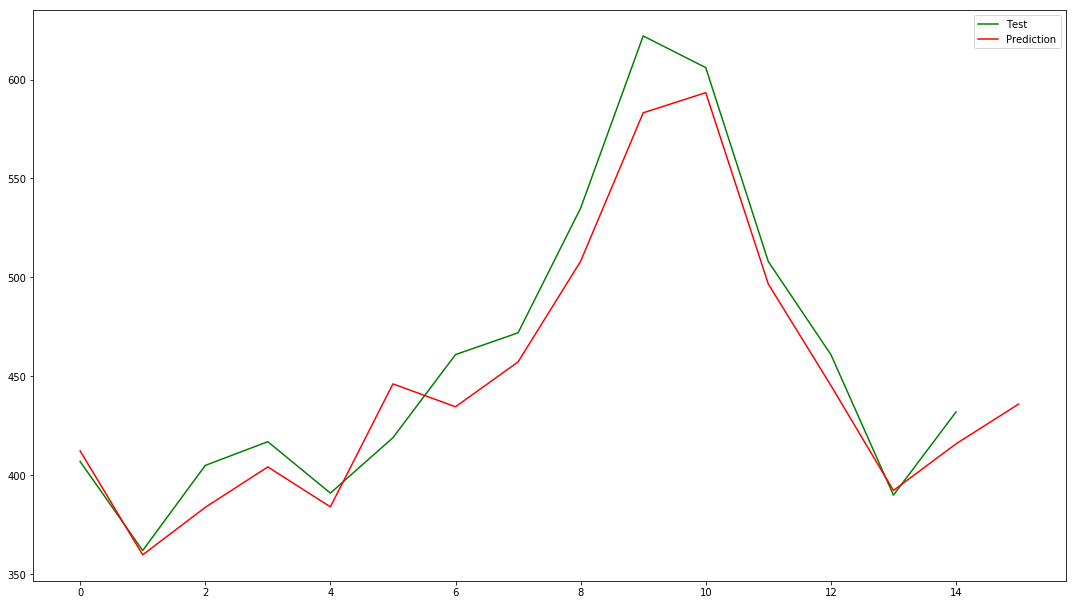

In [275]:
import matplotlib
import matplotlib.pyplot as plt


fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(testSet.values, color='green', label = "Test")
plt.plot(yPrediction, color='red', label = "Prediction")
plt.legend()
plt.savefig("PassengerPrediction.png")

In [276]:
print(sqrt(mean_squared_error(testSet, yPrediction[:-1])))

18.924066095621903
